# Problem:- 
## I have a image dataset of skin cancer disease. I have to trained a model than can identify class of cancer disease.

# import library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix


# device Agnostic code

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and Transformation.

In [3]:
train_dir = Path("C:\\Users\\BKJST\\Desktop\\python\\Project\\skin disease\\output_dataset\\train")
test_dir = Path("C:\\Users\\BKJST\\Desktop\\python\\Project\\skin disease\\output_dataset\\val")

In [4]:
train_transform = transforms.Compose(
    [
        transforms.Resize((64,64)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast =0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std = [0.22, 0.22, 0.22]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std = [0.22, 0.22, 0.22])
    ]
)

In [5]:
train_dataset = datasets.ImageFolder(train_dir,
                                                 transform = train_transform)
test_dataset = datasets.ImageFolder(test_dir,
                                                transform = test_transform)
train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 3285
     Root location: C:\Users\BKJST\Desktop\python\Project\skin disease\output_dataset\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.22, 0.22, 0.22])
            ),
 Dataset ImageFolder
     Number of datapoints: 822
     Root location: C:\Users\BKJST\Desktop\python\Project\skin disease\output_dataset\val
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], st

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size = 256, shuffle = True, num_workers = 0)
test_dataloader = DataLoader(test_dataset, batch_size = 256, shuffle = False, num_workers = 0)

In [7]:
class CNNModel(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int)->None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.global_pool(x)          # (batch, hidden_units, 1, 1)
        x = torch.flatten(x, 1)          # (batch, hidden_units)
        x = self.classifier(x)
        return x


In [8]:
# class names and their index
class_to_idx = train_dataset.class_to_idx
class_to_idx

{'Acitinic Keratosis': 0,
 'Basal Cell Carcinoma': 1,
 'Dermatofibroma': 2,
 'Melanoma': 3,
 'Nevus': 4,
 'Pigmented Benign Keratosis': 5,
 'Seborrheic Keratosis': 6,
 'Squamous Cell Carcinoma': 7,
 'Vascular Lesion': 8}

In [9]:
# number of classes or class names.
num_classes = train_dataset.classes
num_classes

['Acitinic Keratosis',
 'Basal Cell Carcinoma',
 'Dermatofibroma',
 'Melanoma',
 'Nevus',
 'Pigmented Benign Keratosis',
 'Seborrheic Keratosis',
 'Squamous Cell Carcinoma',
 'Vascular Lesion']

In [10]:
# model varible
cnn_model = CNNModel(input_shape = 3,
                     output_shape = len(num_classes),
                     hidden_units = 32).to(device)
cnn_model

CNNModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveAvgPool2d(

In [11]:
import os
def count_length(path):
    count = 0
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith(('.jpg')):
                count += 1
    return count



# check length of train and test dataset.

In [91]:
train_length = count_length(train_dir)
test_length = count_length(test_dir)
train_length, test_length

(3285, 822)

# Training Loop

In [92]:
from tqdm.auto import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr = 0.001)

train_losses, val_losses = [],[]



for epoch in tqdm(range(10)): # i tried appx 10-15 epochs. every time result is same around 40%.
    cnn_model.train()
    running_loss = 0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = cnn_model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
        train_loss = running_loss/train_length # loss divided by total length
    train_losses.append(train_loss)

    # validation
    cnn_model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = cnn_model(images)
            val_loss += criterion(output, labels).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            val_loss = val_loss/ test_length # correct prediction divided by total test length
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Test Loss: {val_loss:.4f} | Test Accuracy: {correct/test_length*100:.2f}%")
    print("-"*50)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.0085 | Test Loss: 0.0027 | Test Accuracy: 11.19%
--------------------------------------------------
Epoch 2 | Train Loss: 0.0080 | Test Loss: 0.0028 | Test Accuracy: 28.10%
--------------------------------------------------
Epoch 3 | Train Loss: 0.0078 | Test Loss: 0.0029 | Test Accuracy: 26.76%
--------------------------------------------------
Epoch 4 | Train Loss: 0.0076 | Test Loss: 0.0029 | Test Accuracy: 32.36%
--------------------------------------------------
Epoch 5 | Train Loss: 0.0075 | Test Loss: 0.0031 | Test Accuracy: 31.14%
--------------------------------------------------
Epoch 6 | Train Loss: 0.0074 | Test Loss: 0.0027 | Test Accuracy: 33.94%
--------------------------------------------------
Epoch 7 | Train Loss: 0.0073 | Test Loss: 0.0028 | Test Accuracy: 35.04%
--------------------------------------------------
Epoch 8 | Train Loss: 0.0072 | Test Loss: 0.0028 | Test Accuracy: 35.89%
--------------------------------------------------
Epoch 9 

#### i tried many times even many days with different different number of epochs. But the test accuracy is between 33-40.
#### i think this is for less amount of dataset.
#### later we will use other technique.

# Create a funciton to predict image.

In [93]:
def predict_image(image_path, model, transform, class_names, device="cuda"):
    model.eval()  # set to evaluation mode
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)  # add batch dim

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_class = probs.argmax(dim=1).item()

    return class_names[pred_class], probs[0][pred_class].item()


In [94]:
from PIL import Image
import torch
class_names = train_dataset.classes  # same order as during training
# img_path = "C:\\Users\\BKJST\\Desktop\\python\\Project\\skin disease\\output_dataset\\train\\Basal Cell Carcinoma\\ISIC_0070534.jpg"
img_path = 'C://Users//BKJST//Desktop//python//Project//skin disease//output_dataset//train//Dermatofibroma//ISIC_0060422.jpg'
# img_path = "C:\\Users\\BKJST\\Desktop\\python\\Project\skin disease\\output_dataset\\val\\Melanoma\\ISIC_0036019.JPG"
pred, confidence = predict_image(img_path, cnn_model, test_transform, class_names, device)
print(f"Prediction: {pred} (confidence: {confidence:.2f})")

Prediction: Melanoma (confidence: 0.22)


In [95]:
pathlist = list(test_dir.glob("*/*.jpg"))
pathlist[:10]

[WindowsPath('C:/Users/BKJST/Desktop/python/Project/skin disease/output_dataset/val/Acitinic Keratosis/ISIC_0053597.jpg'),
 WindowsPath('C:/Users/BKJST/Desktop/python/Project/skin disease/output_dataset/val/Acitinic Keratosis/ISIC_0053799.jpg'),
 WindowsPath('C:/Users/BKJST/Desktop/python/Project/skin disease/output_dataset/val/Acitinic Keratosis/ISIC_0053826.jpg'),
 WindowsPath('C:/Users/BKJST/Desktop/python/Project/skin disease/output_dataset/val/Acitinic Keratosis/ISIC_0053892.jpg'),
 WindowsPath('C:/Users/BKJST/Desktop/python/Project/skin disease/output_dataset/val/Acitinic Keratosis/ISIC_0053950.jpg'),
 WindowsPath('C:/Users/BKJST/Desktop/python/Project/skin disease/output_dataset/val/Acitinic Keratosis/ISIC_0054223.jpg'),
 WindowsPath('C:/Users/BKJST/Desktop/python/Project/skin disease/output_dataset/val/Acitinic Keratosis/ISIC_0054259.jpg'),
 WindowsPath('C:/Users/BKJST/Desktop/python/Project/skin disease/output_dataset/val/Acitinic Keratosis/ISIC_0054908.jpg'),
 WindowsPath('C:

In [96]:
import numpy as np
i = np.random.randint(822) # lenght of test data and using randomly. So everytime no need to write path.
print(i)
path_list = pathlist[i] 
print(path_list)
pred, confidence = predict_image(path_list, cnn_model, test_transform, class_names, device)
print(f"Prediction: {pred} (confidence: {confidence:.2f})")

494
C:\Users\BKJST\Desktop\python\Project\skin disease\output_dataset\val\Pigmented Benign Keratosis\ISIC_0029031.jpg
Prediction: Pigmented Benign Keratosis (confidence: 0.48)


In [97]:
import torch.nn.functional as F

y_true = []  # actual labels
y_pred = []  # predicted labels
y_scores = []
cnn_model.to('cpu')
for images, labels in test_dataloader:
    images = images.to('cpu')
    labels = labels.to('cpu')

    outputs = cnn_model(images)
    _, preds = torch.max(outputs, 1)
    y_score = F.softmax(outputs, dim=1).detach().numpy()  # Now each row sums to 1

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())
    y_scores.extend(y_score)

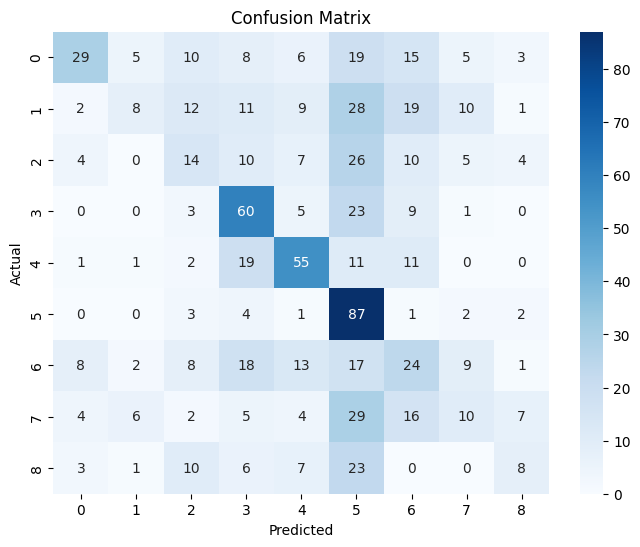

In [98]:
# from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report

In [99]:
print(classification_report(y_true, y_pred, target_names=class_names))

                            precision    recall  f1-score   support

        Acitinic Keratosis       0.57      0.29      0.38       100
      Basal Cell Carcinoma       0.35      0.08      0.13       100
            Dermatofibroma       0.22      0.17      0.19        80
                  Melanoma       0.43      0.59      0.50       101
                     Nevus       0.51      0.55      0.53       100
Pigmented Benign Keratosis       0.33      0.87      0.48       100
      Seborrheic Keratosis       0.23      0.24      0.23       100
   Squamous Cell Carcinoma       0.24      0.12      0.16        83
           Vascular Lesion       0.31      0.14      0.19        58

                  accuracy                           0.36       822
                 macro avg       0.35      0.34      0.31       822
              weighted avg       0.36      0.36      0.32       822



In [100]:
from sklearn.metrics import roc_auc_score


auc_score = roc_auc_score(y_true, y_scores, multi_class='ovr', average='macro')
print(f"Multiclass ROC AUC: {auc_score:.2f}")

Multiclass ROC AUC: 0.78


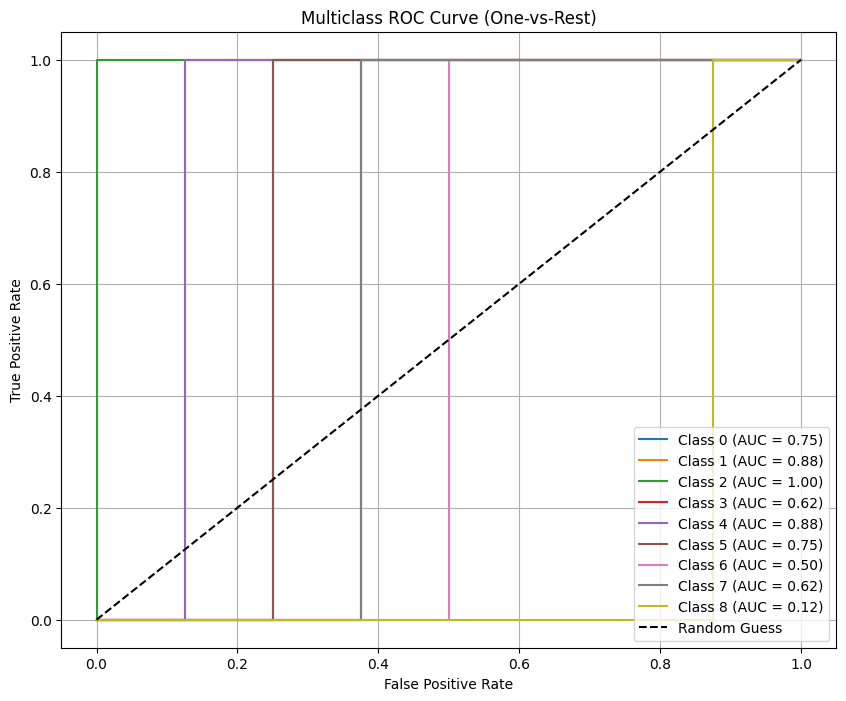

In [101]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


# Step 1: Binarize the labels
classes = np.unique(y_true)
y_true_bin = label_binarize(y_true, classes=classes)

# Step 2: Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true_bin[i], y_scores[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label= f'Class {classes[i]} (AUC = {roc_auc:.2f})')

# Step 3: Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Save, laod and predict  with loaded model or saved model.

In [67]:
torch.save(cnn_model, "cnn_model_07.pth")

In [68]:
loaded_cnn = torch.load("cnn_model_07.pth", weights_only = False)
loaded_cnn.to(device)

CNNModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveAvgPool2d(

In [70]:
i = np.random.randint(822)
print(i)
path_list = pathlist[i]
print(path_list)
pred, confidence = predict_image(path_list, cnn_model, test_transform, class_names, device)
print(f"Prediction: {pred} (confidence: {confidence:.2f})")

120
C:\Users\BKJST\Desktop\python\Project\skin disease\output_dataset\val\Basal Cell Carcinoma\ISIC_0071515.jpg
Prediction: Squamous Cell Carcinoma (confidence: 0.12)


# Pretrained or Fine tunning

In [39]:
from torchvision import models

In [40]:
p_model = models.resnet50(pretrained = True)
# p_model

In [41]:
p_model.fc = nn.Linear(2048, len(class_names))
p_model = p_model.to(device)
p_model.fc

Linear(in_features=2048, out_features=9, bias=True)

In [42]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(p_model.parameters(), lr = 0.001)

train_losses, val_losses = [],[]


start = timer()
for epoch in tqdm(range(9)): # 
    p_model.train()
    running_loss = 0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = p_model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
        train_loss = running_loss/train_length
    train_losses.append(train_loss)

    # validation
    p_model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = p_model(images)
            val_loss += criterion(output, labels).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            val_loss = val_loss/ test_length
    val_losses.append(val_loss)
    end = timer()
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Test Loss: {val_loss:.4f} | Test Accuracy: {correct/test_length*100:.2f}%")
    print(f"time: {end-start}")
    print("-"*50)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.0067 | Test Loss: 0.0001 | Test Accuracy: 25.91%
time: 217.23237029998563
--------------------------------------------------
Epoch 2 | Train Loss: 0.0047 | Test Loss: 0.0007 | Test Accuracy: 44.77%
time: 432.0564120000927
--------------------------------------------------
Epoch 3 | Train Loss: 0.0039 | Test Loss: 0.0020 | Test Accuracy: 56.81%
time: 646.0351438000798
--------------------------------------------------
Epoch 4 | Train Loss: 0.0034 | Test Loss: 0.0015 | Test Accuracy: 60.58%
time: 859.7575148000615
--------------------------------------------------
Epoch 5 | Train Loss: 0.0029 | Test Loss: 0.0011 | Test Accuracy: 57.66%
time: 1074.2929428000934
--------------------------------------------------
Epoch 6 | Train Loss: 0.0024 | Test Loss: 0.0013 | Test Accuracy: 59.37%
time: 1286.3799689000007
--------------------------------------------------
Epoch 7 | Train Loss: 0.0023 | Test Loss: 0.0014 | Test Accuracy: 58.76%
time: 1500.6255370000144
-----------

In [49]:
i = np.random.randint(822)
print(i)
path_list = pathlist[i]
print(path_list)
pred, confidence = predict_image(path_list, p_model, test_transform, class_names, device)
print(f"Prediction: {pred} (confidence: {confidence:.2f})")

34
C:\Users\BKJST\Desktop\python\Project\skin disease\output_dataset\val\Acitinic Keratosis\ISIC_0059360.jpg
Prediction: Acitinic Keratosis (confidence: 0.74)


In [50]:
y_true = []  # actual labels
y_pred = []  # predicted labels
p_model.to('cpu')
for images, labels in test_dataloader:
    images = images.to('cpu')
    labels = labels.to('cpu')

    outputs = p_model(images)
    _, preds = torch.max(outputs, 1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

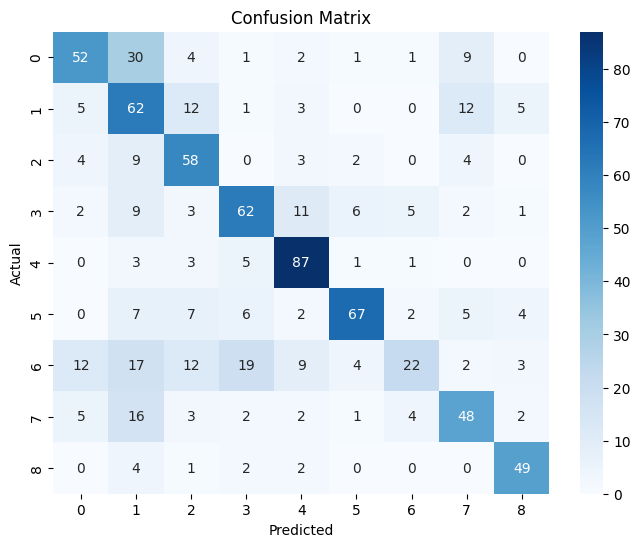

In [53]:
# from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [54]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

                            precision    recall  f1-score   support

        Acitinic Keratosis       0.65      0.52      0.58       100
      Basal Cell Carcinoma       0.39      0.62      0.48       100
            Dermatofibroma       0.56      0.72      0.63        80
                  Melanoma       0.63      0.61      0.62       101
                     Nevus       0.72      0.87      0.79       100
Pigmented Benign Keratosis       0.82      0.67      0.74       100
      Seborrheic Keratosis       0.63      0.22      0.33       100
   Squamous Cell Carcinoma       0.59      0.58      0.58        83
           Vascular Lesion       0.77      0.84      0.80        58

                  accuracy                           0.62       822
                 macro avg       0.64      0.63      0.62       822
              weighted avg       0.64      0.62      0.61       822



In [56]:
torch.save(p_model, 'resnet_model_07.pth') # save model

In [65]:
loaded_p_model = torch.load('resnet_model_07.pth', weights_only = False) # load model
loaded_p_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [107]:
i = np.random.randint(822) # this is code redundency. But this is for trial and testing purposes.
print(i)                   # So i am using same code multiple time because if used here then without define it will return same index.
path_list = pathlist[i]    # if we define function then still we have to inter data path. So for this proble this is not bad.
print(path_list) 
pred, confidence = predict_image(path_list, loaded_p_model, test_transform, class_names, device) # predict with loaded model
print(f"Prediction: {pred} (confidence: {confidence:.2f})")

614
C:\Users\BKJST\Desktop\python\Project\skin disease\output_dataset\val\Seborrheic Keratosis\ISIC_0065772.jpg
Prediction: Seborrheic Keratosis (confidence: 0.67)


### i am using jupyter notebook for research purposes. so code redundancy will ocuurs.

# Conclusion.

We had to develop a model that can classify skin disease. Which i did as much as possible with this dataset and based on my
knowledge. In future i will also work on this project, and release other version.
here i used two model 
* 1. CNN from Scratch.
  2. Pretrained model (Resnet50)

  CNN model not performed as expected.
  Resnet50 also not performed as much as expected. But Better than CNN model. Because we have less amount of data so we not bad. we will try in future.